In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch,torch.utils.data
import gzip
import pickle
import random

#### Loading data

Using part of the code from the 'lecture_data' script

In [2]:
data = pickle.load(gzip.open('mnist.pkl.gz'),encoding='latin1')
train_data = data[0][0]
train_data_label = data[0][1]
val_data, val_data_label = zip(*random.sample(list(zip(data[0][0], data[0][1])), 100))
test_data = data[1][0]
test_data_label = data[1][1]

#### Visualise some data

Visualising some images with the corresponding label to check if all is good

In [3]:
def display_img(img, lab):
    lab = np.argmax(lab)
    plt.figure()
    plt.imshow(img.reshape((28, 28)), interpolation='nearest', cmap='binary')
    plt.title('label: ' + str(lab))

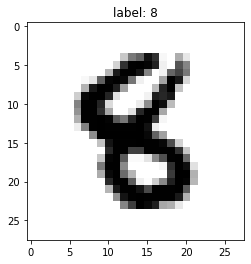

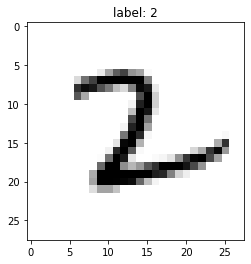

In [4]:
for i in range(2):
    display_img(test_data[i], test_data_label[i])

#### Parameters

Parameters of the network

In [5]:
learning_rate = .001
epochs = 5
hist_interval = 500
loss_h = []
acc_h = []
nb_entries = len(train_data[0])                          # 784
# Number of hidden neurons, arbitrary number
nb_neurons_h = 128                                       # 26
# Number of output neurons = number of classes
nb_neurons_o = len(train_data_label[0])                  # 10
# Weights of the hidden layer
w_h = np.zeros((nb_neurons_h, nb_entries))               # w_h: (26, 784)
# Weights of the output layer
w_o = np.random.randn(nb_neurons_o, nb_neurons_h)        # w_o: (10, 26)
# Biases of the hidden layer
b_h = np.zeros((nb_neurons_h))                           # b_h: (26)
# Biases of the output layer
b_o = np.random.randn(nb_neurons_o)                      # b_o: (10)

#### Perceptron implementation

We define the 'fit' function that we can call to fit the network to the training data.

We can then call predict to check the accuracy on the test data.

In [6]:
def sigmoid(y):
    return 1. / (1. + np.exp(-y))

def der_sigmoid(y):
    return np.multiply(y, (1 - y))

In [7]:
def predict():
    accuracy = 0
    # For each test item
    for x, t in zip(test_data, test_data_label):
        # Compute the output of each hidden neuron
        y_h = sigmoid(np.dot(w_h, x) + b_h)                  # w_h: (26, 784), x: (784,), b_h: (26,), y_h: (26,)
        # Compute the output of each output neuron
        y_o = np.dot(w_o, y_h) + b_o                         # w_h: (10, 26), y_h: (26,), b_o: (10,), y_o: (10,)
        # Compare the desired output with the predicted one 
        accuracy += np.argmax(y_o) == np.argmax(t)
    # Return the accuracy of the network on the test set
    return accuracy / len(test_data)

def val():
    accuracy = 0
    # For each test item
    for x, t in zip(val_data, val_data_label):
        # Compute the output of each hidden neuron
        y_h = sigmoid(np.dot(w_h, x) + b_h)                  # w_h: (26, 784), x: (784,), b_h: (26,), y_h: (26,)
        # Compute the output of each output neuron
        y_o = np.dot(w_o, y_h) + b_o                         # w_h: (10, 26), y_h: (26,), b_o: (10,), y_o: (10,)
        # Compare the desired output with the predicted one 
        accuracy += np.argmax(y_o) == np.argmax(t)
    # Return the accuracy of the network on the test set
    return accuracy / len(val_data)

def fit():
    global w_h, w_o, b_h, b_o
    for _ in range(epochs):
        i = 0
        cumul_loss = .0
        # For each training item, x is the image and t is the corresponding label
        for x, t in zip(train_data, train_data_label):
            # Compute the output of each hidden neuron
            y_h = sigmoid(np.dot(w_h, x) + b_h)              # w_h: (26, 784), x: (784,), b_h: (26,), y_h: (26,)
            # Compute the output of each output neuron
            y_o = np.dot(w_o, y_h) + b_o                     # w_o: (10, 26), y_h: (26,), b_o: (10,), y_o: (10,)
            # Compute the error of the output layer
            e_o = t - y_o                                    # e_o: (10,)
            # Compute the error of the hidden layer
            e_h = der_sigmoid(y_h) * np.dot(e_o, w_o)        # y_h: (10,), e_o: (10,), w_o: (10, 26), e_h: (26,)

            # Create a matrix containing the input image by the number of hidden neurons
            # The matrix is transposed
            m_h = np.transpose([x] * nb_neurons_h)           # m_h: (784, 26)
            # Compute the delta that will be add to the weights
            dw_h = learning_rate * m_h * e_h                 # m_h: (784, 26), e_h: (26,), dw_h: (784, 26)
            # Add the delta to the weights
            w_h += np.transpose(dw_h)                        # w_h: (26, 784)
            b_h += learning_rate * e_h

            # Create a matrix containing the input of the output layer (y_c) by the number of output neurons
            # The matrix is transposed so we can multiply it to a (10,) vector
            m_o = np.transpose([y_h] * nb_neurons_o)         # m_o: (26, 10)
            # Compute the delta that will be add to the weights
            dw_o = learning_rate * m_o * e_o                 # m_o: (26, 10), e_o: (10,), dw_o: (26, 10)
            # Add the delta to the weights
            w_o += np.transpose(dw_o)                        # w_o: (10, 26)
            b_o += learning_rate * e_o

            i += 1
            cumul_loss += (e_o**2).mean(axis=0)
            if i % hist_interval == hist_interval - 1:
                acc_h.append(val())
            if i % 10 == 10 - 1:
                loss_h.append(cumul_loss / 10)
                cumul_loss = .0

In [8]:
fit()

In [9]:
acc = predict()
print('Accuracy: ' + str(acc))

Accuracy: 0.9384285714285714


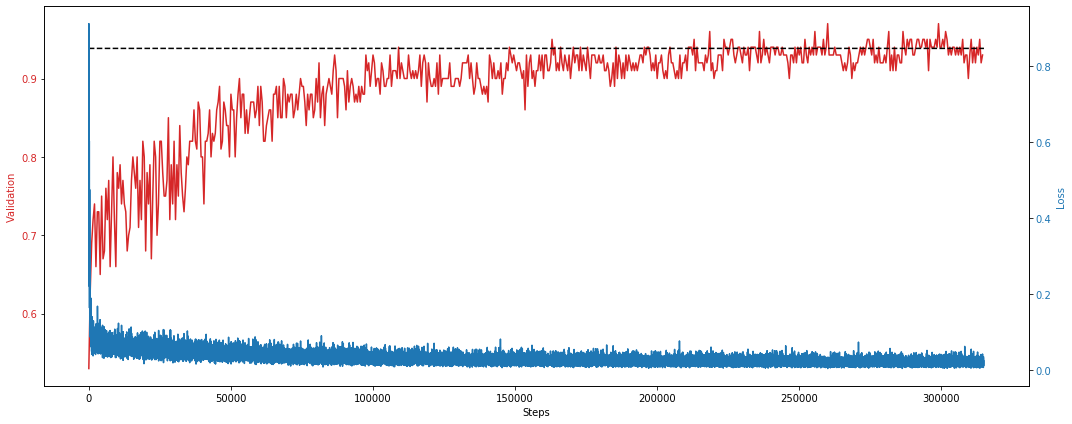

In [10]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Steps')
ax1.set_ylabel('Validation', color=color)
ax1.plot([i * hist_interval for i in range(len(acc_h))], acc_h, '-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1
ax2.plot([i * 10 for i in range(len(loss_h[10:]))], loss_h[10:], '-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.plot([acc] * len(acc_h) * hist_interval, 'k--')
plt.gcf().set_size_inches(15, 6)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()